<a href="https://colab.research.google.com/github/jamartinezv2023/deeplearning/blob/main/02_preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#¿Cómo funciona?

In [1]:
!pip install kaggle


In [2]:
from google.colab import files
files.upload()  # selecciona kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"josemartinez2023","key":"73a5a964a37b93eff5d8df3b5e1095d5"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d martj42/international-football-results-from-1872-to-2017
!unzip international-football-results-from-1872-to-2017.zip


Dataset URL: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017
License(s): CC0-1.0
  0% 0.00/1.16M [00:00<?, ?B/s]
100% 1.16M/1.16M [00:00<00:00, 565MB/s]
Archive:  international-football-results-from-1872-to-2017.zip
  inflating: former_names.csv        
  inflating: goalscorers.csv         
  inflating: results.csv             
  inflating: shootouts.csv           


Shape inicial: (48532, 9)


100%|██████████| 48532/48532 [00:03<00:00, 15702.06it/s]


X_seq shape: (48532, 10)
X_static shape: (48532, 2)
y shape: (48532,)
✅ Archivos guardados: X_seq.npy, X_static.npy, y.npy


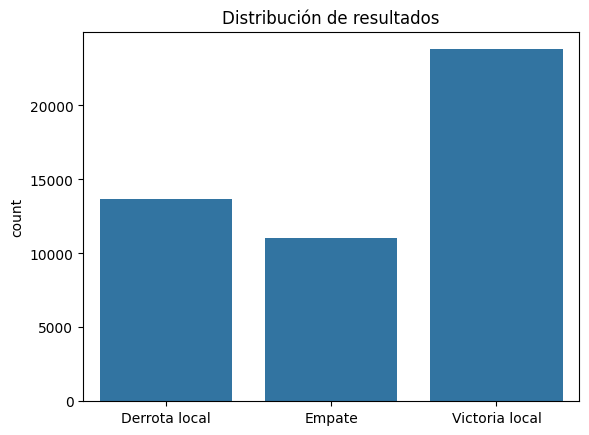

In [5]:
# File: notebooks/02-preprocesado.ipynb

# ---
# # Preprocesamiento de Datos - Proyecto Deep Learning Fútbol
# ---
# Este notebook toma el CSV original de Kaggle y lo transforma en arrays numpy:
# - X_seq.npy (secuencias de partidos para modelos temporales)
# - X_static.npy (features estáticas de cada partido)
# - y.npy (etiquetas de resultado: 0=derrota, 1=empate, 2=victoria)
# ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm

# ======================
# 1. Cargar Dataset
# ======================
df = pd.read_csv("results.csv")
print("Shape inicial:", df.shape)
df.head()

# ======================
# 2. Limpieza básica
# ======================
# Eliminar nulos y partidos sin marcador válido
df = df.dropna(subset=['home_score', 'away_score'])
df = df[df['home_score'] >= 0]
df = df[df['away_score'] >= 0]

# Normalizar nombres de equipos
df['home_team'] = df['home_team'].str.strip()
df['away_team'] = df['away_team'].str.strip()

# ======================
# 3. Generar variable objetivo (y)
# ======================
def resultado(row):
    if row['home_score'] > row['away_score']:
        return 2  # victoria local
    elif row['home_score'] < row['away_score']:
        return 0  # derrota local
    else:
        return 1  # empate

df['target'] = df.apply(resultado, axis=1)
df[['home_team','away_team','home_score','away_score','target']].head()

# ======================
# 4. Features estáticas
# ======================
static_features = df[['home_score', 'away_score']]
scaler = StandardScaler()
X_static = scaler.fit_transform(static_features)

# ======================
# 5. Features secuenciales (historial por equipo)
# ======================
# Ejemplo: historial de últimos 5 partidos por equipo
window_size = 5

# Inicializar secuencias
teams = pd.concat([df['home_team'], df['away_team']]).unique()
historial = {team: [] for team in teams}
X_seq = []
y_seq = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    home = row['home_team']
    away = row['away_team']

    # Representar historial de goles recientes
    home_hist = historial[home][-window_size:]
    away_hist = historial[away][-window_size:]

    # Padding con ceros si no hay suficientes partidos
    home_hist = [0]*(window_size - len(home_hist)) + home_hist
    away_hist = [0]*(window_size - len(away_hist)) + away_hist

    # Concatenar en una sola secuencia
    seq = home_hist + away_hist
    X_seq.append(seq)
    y_seq.append(row['target'])

    # Actualizar historial con diferencia de goles
    historial[home].append(row['home_score'] - row['away_score'])
    historial[away].append(row['away_score'] - row['home_score'])

X_seq = np.array(X_seq)
y = np.array(y_seq)

print("X_seq shape:", X_seq.shape)
print("X_static shape:", X_static.shape)
print("y shape:", y.shape)

# ======================
# 6. Guardado
# ======================
np.save("X_seq.npy", X_seq)
np.save("X_static.npy", X_static)
np.save("y.npy", y)

print("✅ Archivos guardados: X_seq.npy, X_static.npy, y.npy")

# ======================
# 7. Visualización de balance de clases
# ======================
sns.countplot(x=y)
plt.xticks([0,1,2], ["Derrota local","Empate","Victoria local"])
plt.title("Distribución de resultados")
plt.show()
